In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context('talk')
plt.style.use('paper.mplstyle')

from multiprocessing import Pool
import time

# (1) Galaxy Matter Density Profile

Here, we prepare the galaxy mass density profile based on McMillan 2011 (https://doi.org/10.1111/j.1365-2966.2011.18564.x) as a function of coordinate $(R,z)$ (assuming cylindrical symmetry).

## (1-1) Bulge

$$
\rho_b(R,z) = \frac{\rho_{b,0}}{(1+r'/r_0)^\alpha}\exp[-(r'/r_\text{cut})]
$$
where
$$
r' = \sqrt{R^2 + (z/q)^2}
$$
with<br>
$\alpha=1.8$,<br>
$r_0=0.075$kpc,<br>
$r_\text{cut}=2.1$kpc, and<br>
$\rho_{b,0}=9.93\times10^{10} \text{M}_\odot\text{kpc}^{-3}$

In [2]:
def init_bulge():
    global alpha, r0, r_cut, rho_b0, q
    alpha = 1.8
    r0 = 0.075
    r_cut = 2.1
    rho_b0 = 9.93e10 
    q = 0.5
    

def rho_bulge(R,z):
    global rho_b0, r0, alpha, r_cut, q
    rp = np.sqrt(R**2+(z/q)**2)
    return rho_b0/(1+rp/r0)**alpha * np.exp(-rp/r_cut)

## (1-2) Disk

$$
\rho_d(R,z) = \frac{\Sigma_{d,0}}{2z_d}\exp\left(-\frac{|z|}{z_d} - \frac{R}{R_d}\right)
$$

for both 'thin' and 'thick' disks.
Parameters:<br>
$\Sigma_{d,0,\text{thin}} = 816.6 \text{M}_\odot\text{pc}^{-2} = 8.16\times10^{8} \text{M}_\odot\text{kpc}^{-2}$,<br>
$\Sigma_{d,0,\text{thick}} = 209.5 \text{M}_\odot\text{pc}^{-2} = 2.10\times10^{8} \text{M}_\odot\text{kpc}^{-2}$,<br>
$R_{d,\text{thin}} = 2.90$ kpc,<br>
$R_{d,\text{thick}} = 3.31$ kpc,<br>
$z_{d,\text{thin}} = 0.3$ kpc,<br>
$z_{d,\text{thick}} = 0.9$ kpc,<br>


In [3]:
def rho_disk(R,z,sig_d0,z_d,R_d):
    return (sig_d0/(2*z_d))*np.exp(-(abs(z)/z_d)-(R/R_d))

In [4]:
def init_disk():
    global sig_d0_thin,z_d_thin,R_d_thin
    global sig_d0_thick,z_d_thick,R_d_thick
    sig_d0_thin = 8.16e8
    sig_d0_thick = 2.10e8
    R_d_thin = 2.90
    R_d_thick = 3.31
    z_d_thin = 0.3
    z_d_thick = 0.9

In [5]:
def rho_disk_total(R,z):
    thin  = rho_disk(R,z,sig_d0_thin, z_d_thin, R_d_thin)
    thick = rho_disk(R,z,sig_d0_thick,z_d_thick,R_d_thick)
    return thin+thick

## (1-3) DM halo
spherically symmetric NFW profile
$$
\rho_h(r) = \frac{\rho_{h,0}}{\frac{r}{r_h}\left(1+\frac{r}{r_h}\right)^2}
$$

with<br>
$\rho_{h,0}=0.00846\text{M}_\odot\text{pc}^{-3}=8.46\times10^{6}\text{M}_\odot\text{kpc}^{-3}$<br>
$r_h = 20.2$ kpc

In [24]:
def init_halo():
    global rho_h0, r_h
    rho_h0 = 8.46e6
    r_h = 20.2

def rho_halo(r):
    global rho_h0, r_h
    x = r/r_h
    return rho_h0/(x*(1+x)**2)

## (1-4) total mass density

In [7]:
def initialize_params():
    init_bulge()
    init_disk()
    init_halo()

In [8]:
# at z=0:
initialize_params()
R = np.linspace(0,20,1000)
bulge = rho_bulge(R,0)
disk = rho_disk_total(R,0)
halo = rho_halo(R)
rho_total = bulge + disk + halo

/home/sterlingym/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Text(0, 0.5, 'mass density [$M_\\odot/kpc^3$]')

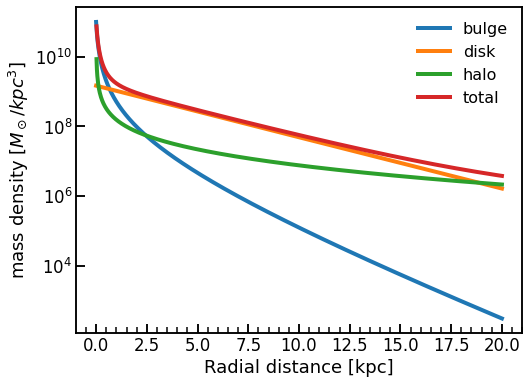

In [9]:
plt.plot(R,bulge,label='bulge')
plt.plot(R,disk,label='disk')
plt.plot(R,halo,label='halo')
plt.plot(R,rho_total,label='total')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial distance [kpc]')
plt.ylabel(r'mass density [$M_\odot/kpc^3$]')

# (2) calculate $M_\text{in}(r)$: enclosed mass inside the sphere at radius r

$M_\text{in}(r)$ determines the force acting on objects at radius $r$:

$$
M_\text{in}(r) = \sum_i \left[\int_{-\pi}^\pi\int_0^{2\pi}\int_0^r \rho_i(r',\theta,\phi)r'^2\sin\theta\mathrm dr' \mathrm d\theta \mathrm d\phi\right]
$$
where $i$ is for bulge, thin disk, thick disk, and DM halo.

Here, because we plan to simulate in 2D, we only care about the gravity acting on the plane.<br>
If one plans to expand this to 3D, a more complicated and larger set of calculations needs to be done.

In [25]:
def calc_Mr_bulge(r):
    # bulge: ring integration
    R_list = np.linspace(1e-9,r,1000)
    dR = R_list[1]-R_list[0]
    mass = 0
    for R in R_list:
        if r==R:
            continue
        else:
            zlim = np.sqrt(r**2-R**2)
            z_list = np.linspace(-zlim,zlim,int(2*zlim/dR)+2)
            dz = z_list[1]-z_list[0]
            for z in z_list:
                ring = rho_bulge(R,z)*2*np.pi*R*dR*dz
                mass += ring
    return mass

def calc_Mr_disk(r):
    # disk: ring integration
    R_list = np.linspace(1e-9,r,1000)
    dR = R_list[1]-R_list[0]
    mass = 0
    for R in R_list:
        if r==R:
            continue
        else:
            zlim = np.sqrt(r**2-R**2)
            z_list = np.linspace(-zlim,zlim,int(2*zlim/dR)+2)
            dz = z_list[1]-z_list[0]
            for z in z_list:
                ring = rho_disk_total(R,z)*2*np.pi*R*dR*dz
                mass += ring
    return mass

def calc_Mr_halo(r):
    # halo: spherical shell integration (much faster)
    R_list = np.linspace(1e-9,r,1000)
    dR = R_list[1]-R_list[0]
    mass = 0
    for R in R_list:
        mass += 4*np.pi*R**2*rho_halo(R)*dR
    return mass

## (2-1) evaluation points & parameters

```Rmax``` should be at least the size of the galaxy. Above this point the enclosed mass is fixed.<br>
```R_list``` is the list of points at which M(r) is evaluated. The larger number of evaluation points we have, the better it is (but it takes time to compute this value).

In [11]:
Rmax = 30 #kpc
R_list = np.linspace(1e-6,Rmax,1000)

In [13]:
np.save('data/R_list',R_list)

## (2-2) Bulge

In [12]:
# calculate bulge
start_time = time.time()
pool = Pool()
bulge_mass_list = pool.map(calc_Mr_bulge,R_list)
pool.close()
pool.join()
print('execution time: {:.3f} seconds'.format(time.time()-start_time))

execution time: 2239.087 seconds


In [14]:
np.save('data/bulge_mass_list',bulge_mass_list)

## (2-3) Disk

In [15]:
# calculate disk
start_time = time.time()
pool = Pool()
disk_mass_list = pool.map(calc_Mr_disk,R_list)
pool.close()
pool.join()
print('execution time: {:.3f} seconds'.format(time.time()-start_time))

execution time: 2166.596 seconds


In [16]:
np.save('data/disk_mass_list',disk_mass_list)

## (2-4) DM Halo

In [26]:
# calculate halo
start_time = time.time()
pool = Pool()
halo_mass_list = pool.map(calc_Mr_halo,R_list)
pool.close()
pool.join()
print('execution time: {:.3f} seconds'.format(time.time()-start_time))

execution time: 0.560 seconds


In [27]:
np.save('data/halo_mass_list',halo_mass_list)

## (2-5) quick check

We expect the bulge to dominate first, followed by the disk, and then DM halo.

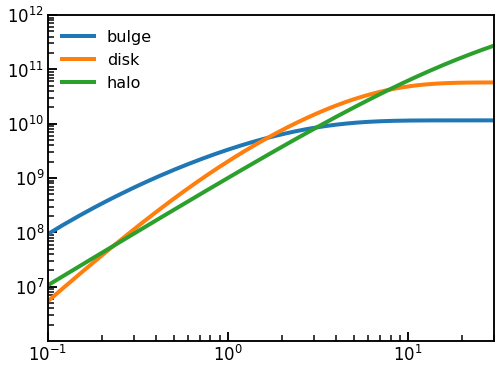

In [55]:
plt.plot(R_list,bulge_mass_list,label='bulge')
plt.plot(R_list,disk_mass_list,label='disk')
plt.plot(R_list,halo_mass_list,label='halo')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,30)
plt.ylim(1e6,1e12)
plt.yticks([1e7,1e8,1e9,1e10,1e11,1e12]);